### Import libraries

In [1]:
import sys
import os
import gc
from functools import partial
import warnings
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Machine_Learning/scripts/")

In [3]:
from DataSetUp import *
from EmbedCarPrice import *
%load_ext autoreload
%autoreload 2

In [4]:
EmbedCarPrice.set_gpu_limit(6)

### Split none onehot encoded data into train,dev and test for categorical embedding

In [5]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_data_merged.csv")
features, y = data.drop("price",axis=1), data.price 

In [6]:
data_setup = DataSetUp(features,y)
X_train,X_dev,X_test,y_train,y_dev,y_test = data_setup.data_split(2020,0.1,True,2020,0.11)

In [7]:
X_train.shape,X_dev.shape,X_test.shape,y_train.shape,y_dev.shape,y_test.shape

((79447, 8), (9820, 8), (9919, 8), (79447,), (9820,), (9919,))

### We will embed columns model, transmission, fuelType, and brand

--- 

### Garbage collect

In [8]:
gc.collect()
%reset -f out

Flushing output cache (1 entries)


### Setting up some constants for base model

In [9]:
EMBED_COLS = ["model","transmission","brand","fuelType"]
NONEMBED_COLS = [c for c in X_train.columns if c not in EMBED_COLS]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 1e-3
numeric_size = [64,32]
model_size = [1024,512,256]
DROPOUT= [0.2,0.2]
METRICS = ["MAPE","MAE"]

In [10]:
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss",mode="min",
                                        patience=10,verbose=1,restore_best_weights=True)

* model embed model input 
* transmission embed model input
* brand embed model input 
* fuelType embed model input 
* numeric input data 

### Perform categorical feature transformation

In [11]:
data_setup.categorical_mapping(X_train,EMBED_COLS)

In [12]:
X_train_list,X_dev_list  = data_setup.cate_data_list(X_train),data_setup.cate_data_list(X_dev)
X_test_list,features_list = data_setup.cate_data_list(X_test), data_setup.cate_data_list(features)

In [13]:
X_train_dataset, X_dev_dataset = (X_train_list,y_train),(X_dev_list,y_dev)

In [14]:
base_embed_model = EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS, 
                                                   X_train,numeric_size,
                                                   model_size,DROPOUT,METRICS,lr)

In [15]:
carPrice_embed = EmbedCarPrice(base_embed_model,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [16]:
carPrice_embed.regression_metrics(X_train_list,y_train,"train",True,X_train_dataset,X_dev_dataset,0)

Restoring model weights from the end of the best epoch.
Epoch 00062: early stopping


,r2_score,rmse,price_diff_abs_max
train,0.942819,2358.714682,712.517141


In [22]:
carPrice_embed.regression_metrics(X_test_list,y_test,"test",False)

,r2_score,rmse,price_diff_abs_max
test,0.936816,2424.685632,723.541091


In [17]:
carPrice_embed.save_model("cate_embed_base_model.h5")

In [18]:
base_embed_model = EmbedCarPrice.load_model("cate_embed_base_model.h5")

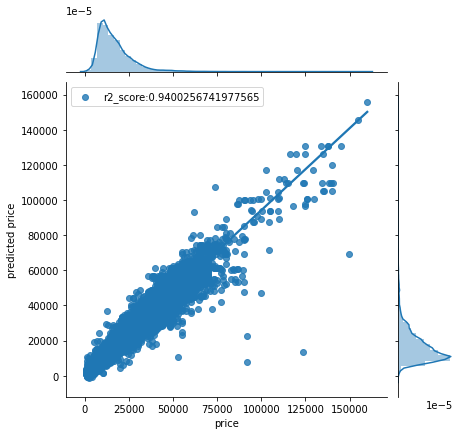

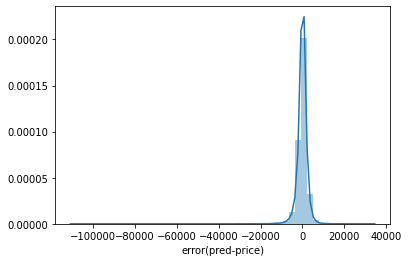

In [19]:
carPrice_embed.plot_pred_price(features_list,y)

In [20]:
price_table = carPrice_embed.price_diff(features,y,features_list)

In [21]:
price_table.head(20)

,model,transmission,fuelType,brand,binned_year,mil_cat,binned_mpg,engine_binned,price_diff_pct,price_diff_abs
11984,Golf,Manual,Diesel,vw,1,0,3,0,712.517141,712.517141
20061,Beetle,Automatic,Petrol,vw,1,0,1,0,656.857935,656.857935
39711,C Class,Automatic,Diesel,merc,1,2,1,1,589.248667,589.248667
71819,Mondeo,Manual,Diesel,ford,1,0,2,0,537.679149,537.679149
39978,A Class,Manual,Petrol,merc,1,5,1,0,466.072791,466.072791
44539,Corsa,Manual,Petrol,vauxhall,1,4,3,0,443.787188,443.787188
77582,Santa Fe,Manual,Petrol,hyundi,1,4,1,1,376.180623,376.180623
69135,Mondeo,Manual,Diesel,ford,1,4,2,0,366.225297,366.225297
39540,M Class,Semi-Auto,Petrol,merc,1,5,1,1,347.244087,347.244087
40171,A Class,Automatic,Petrol,merc,1,4,2,0,296.651123,296.651123


### similar to regular NN

### Let's try a bigger model and see if it helps and increase embed size with slower learning rate 

In [22]:
EMBED_COLS = ["model","transmission","brand","fuelType"]
NONEMBED_COLS = [c for c in X_train.columns if c not in EMBED_COLS]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [23]:
bigger_embed_model = EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS,
                                                     X_train,numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [24]:
bigger_embed_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

In [25]:
carPrice_embed_bigger = EmbedCarPrice(bigger_embed_model,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [27]:
carPrice_embed_bigger.regression_metrics(X_train_list,y_train,"train",True,X_train_dataset,X_dev_dataset,0)

,r2_score,rmse,price_diff_abs_max
train,0.943778,2338.85621,586.237911


In [30]:
carPrice_embed_bigger.regression_metrics(X_test_list,y_test,"test",False)

,r2_score,rmse,price_diff_abs_max
test,0.937483,2411.862441,381.454026


In [32]:
carPrice_embed_bigger.save_model("bigger_embed.h5")

In [33]:
bigger_embed = EmbedCarPrice.load_model("bigger_embed.h5")

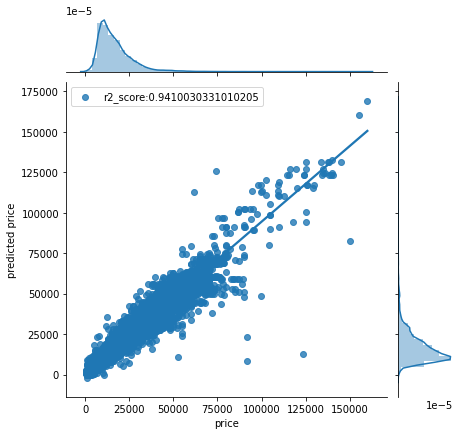

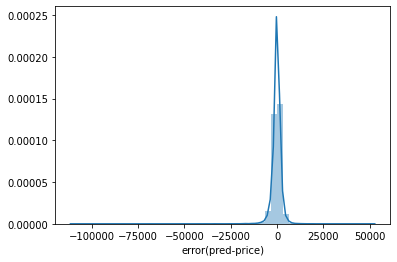

In [35]:
carPrice_embed_bigger.plot_pred_price(features_list,y)

In [36]:
price_table = carPrice_embed_bigger.price_diff(features,y,features_list)

In [37]:
price_table.head(20)

,model,transmission,fuelType,brand,binned_year,mil_cat,binned_mpg,engine_binned,price_diff_pct,price_diff_abs
11984,Golf,Manual,Diesel,vw,1,0,3,0,586.237911,586.237911
20061,Beetle,Automatic,Petrol,vw,1,0,1,0,559.989724,559.989724
39711,C Class,Automatic,Diesel,merc,1,2,1,1,510.940831,510.940831
71819,Mondeo,Manual,Diesel,ford,1,0,2,0,422.900654,422.900654
39540,M Class,Semi-Auto,Petrol,merc,1,5,1,1,404.074444,404.074444
39978,A Class,Manual,Petrol,merc,1,5,1,0,381.454026,381.454026
77582,Santa Fe,Manual,Petrol,hyundi,1,4,1,1,372.287882,372.287882
44539,Corsa,Manual,Petrol,vauxhall,1,4,3,0,339.755958,339.755958
47138,Astra,Manual,Petrol,vauxhall,0,4,1,0,-310.644557,310.644557
69135,Mondeo,Manual,Diesel,ford,1,4,2,0,277.277308,277.277308


### Performance is slightly better but still have bin year and mil category issues. 

### Try embed other binned numerical features and see if the performance improves 

In [39]:
EMBED_COLS = ["model","transmission","brand","fuelType","binned_year","mil_cat","binned_mpg","engine_binned"]
NONEMBED_COLS = [c for c in features.columns if c not in EMBED_COLS]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [41]:
data_setup.categorical_mapping(X_train,EMBED_COLS)

In [42]:
X_train_list,X_dev_list  = data_setup.cate_data_list(X_train),data_setup.cate_data_list(X_dev)
X_test_list,features_list = data_setup.cate_data_list(X_test), data_setup.cate_data_list(features)

In [44]:
X_train_dataset, X_dev_dataset = (X_train_list,y_train),(X_dev_list,y_dev)

In [47]:
all_embed_model = EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS, 
                                                   X_train,numeric_size,
                                                   model_size,DROPOUT,METRICS,lr,2)

In [48]:
all_embed_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [49]:
carPrice_embed_all = EmbedCarPrice(all_embed_model,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [51]:
carPrice_embed_all.regression_metrics(X_train_list,y_train,"train",True,X_train_dataset,X_dev_dataset,0)

,r2_score,rmse,price_diff_abs_max
train,0.942303,2369.327209,535.029741


In [52]:
carPrice_embed_all.regression_metrics(X_test_list,y_test,"test",False)

,r2_score,rmse,price_diff_abs_max
test,0.937183,2417.635195,318.683594


In [53]:
carPrice_embed_all.save_model("All_embed.h5")

In [54]:
all_embed = EmbedCarPrice.load_model("All_embed.h5")

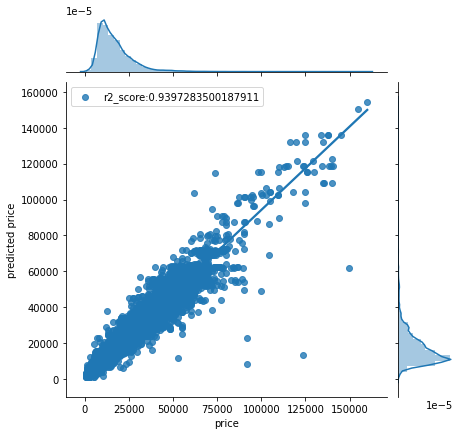

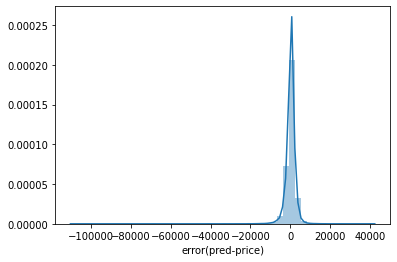

In [55]:
carPrice_embed_all.plot_pred_price(features_list,y)

In [56]:
price_table = carPrice_embed_all.price_diff(features,y,features_list)
price_table.head(20)

,model,transmission,fuelType,brand,binned_year,mil_cat,binned_mpg,engine_binned,price_diff_pct,price_diff_abs
44539,Corsa,Manual,Petrol,vauxhall,1,4,3,0,535.029741,535.029741
11984,Golf,Manual,Diesel,vw,1,0,3,0,483.237857,483.237857
20061,Beetle,Automatic,Petrol,vw,1,0,1,0,479.582511,479.582511
77582,Santa Fe,Manual,Petrol,hyundi,1,4,1,1,429.646200,429.646200
71819,Mondeo,Manual,Diesel,ford,1,0,2,0,386.873391,386.873391
39711,C Class,Automatic,Diesel,merc,1,2,1,1,380.982605,380.982605
87481,3 Series,Automatic,Petrol,bmw,0,4,1,1,347.135010,347.135010
69135,Mondeo,Manual,Diesel,ford,1,4,2,0,329.732313,329.732313
39978,A Class,Manual,Petrol,merc,1,5,1,0,318.683594,318.683594
72349,Focus,Manual,Petrol,ford,1,4,2,0,312.472146,312.472146


### Slightly improved, still have same issues with older year. Let's import original raw data

In [74]:
data_raw = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_data_raw.csv")
features_raw,y_raw = data_raw.drop("price",axis=1),data_raw.price
X_train_raw,X_dev_raw,X_test_raw,y_train_raw,y_dev_raw,y_test_raw = data_setup_raw.data_split(2020,0.1,True,2020,0.11)

In [79]:
EMBED_COLS = ["model","transmission","brand","fuelType","year"]
NONEMBED_COLS = [c for c in X_train_raw.columns if c not in EMBED_COLS]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [76]:
data_setup_raw = DataSetUp(features_raw,y_raw)

In [77]:
data_setup_raw.categorical_mapping(X_train_raw,EMBED_COLS)

In [78]:
X_train_list_r,X_dev_list_r = data_setup_raw.cate_data_list(X_train_raw),data_setup_raw.cate_data_list(X_dev_raw)
X_test_list_r, features_list_r = data_setup_raw.cate_data_list(X_test_raw),data_setup_raw.cate_data_list(features_raw)

In [84]:
train_dataset_r,dev_dataset_r = (X_train_list_r,y_train_raw),(X_dev_list_r,y_dev_raw)

In [81]:
carPrice_embed_raw = EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS,X_train_raw,
                                                     numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [82]:
carPrice_embed_raw.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [83]:
carPrice_embed_raw = EmbedCarPrice(carPrice_embed_raw,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [95]:
carPrice_embed_raw.regression_metrics(X_train_list_r,y_train_raw,"train",True,train_dataset_r,dev_dataset_r,0)

,r2_score,rmse,price_diff_abs_max
train,0.935434,2506.401961,991.591564


In [96]:
carPrice_embed_raw.regression_metrics(X_test_list_r,y_test_raw,"test",False)

,r2_score,rmse,price_diff_abs_max
test,0.931087,2532.231179,435.971154


In [97]:
carPrice_embed_raw.save_model("model_embed_raw.h5")

In [98]:
embed_model_r = EmbedCarPrice.load_model("model_embed_raw.h5")

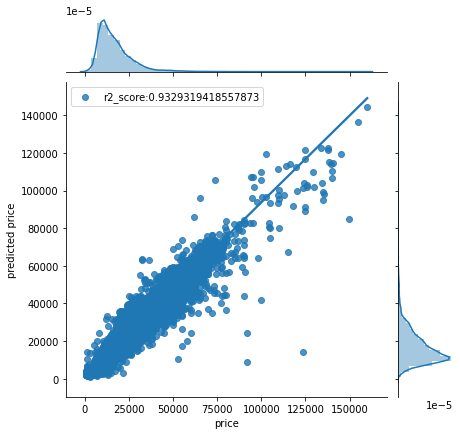

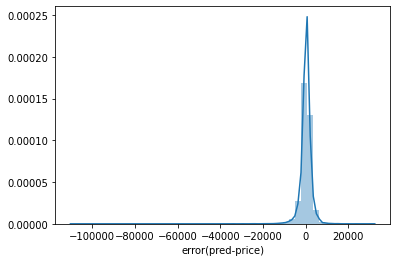

In [99]:
carPrice_embed_raw.plot_pred_price(features_list_r,y_raw)

In [100]:
price_table = carPrice_embed_raw.price_diff(features_raw,y_raw,features_list_r)
price_table.head(20)

,model,year,transmission,mileage,fuelType,mpg,engineSize,brand,price_diff_pct,price_diff_abs
11984,Golf,2008,Manual,1,Diesel,53.3,1.9,vw,991.591564,991.591564
71819,Mondeo,2008,Manual,1,Diesel,47.9,2.0,ford,721.776366,721.776366
72016,Focus,2003,Manual,177644,Petrol,41.5,1.6,ford,717.770626,717.770626
44539,Corsa,2002,Manual,99842,Petrol,50.4,1.0,vauxhall,529.433643,529.433643
27964,Octavia,2010,Manual,300000,Diesel,57.6,1.9,skoda,483.391175,483.391175
20061,Beetle,2001,Automatic,1,Petrol,29.7,2.0,vw,477.972270,477.972270
47201,Astra,2001,Manual,159000,Petrol,40.4,1.6,vauxhall,453.107476,453.107476
39978,A Class,2003,Manual,109090,Petrol,40.0,1.4,merc,435.971154,435.971154
52100,Zafira,2013,Manual,279000,Diesel,55.4,1.7,vauxhall,404.649173,404.649173
54900,Agila,2003,Manual,90000,Petrol,43.5,1.2,vauxhall,401.095486,401.095486


### Let's use binned numeric data instead of raw numeric value

In [107]:
EMBED_COLS = ["model","transmission","brand","fuelType","year","mil_cat","binned_mpg","engine_binned"]
NONEMBED_COLS = [c for c in X_train_c.columns if c not in EMBED_COLS]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [109]:
combined = data.drop("binned_year",axis=1).merge(data_raw["year"],left_index=True,right_index=True)
features_c,y_c = combined.drop("price",axis=1), combined.price

In [110]:
data_setup_c = DataSetUp(features_c,y)

In [111]:
X_train_c,X_dev_c,X_test_c,y_train_c,y_dev_c,y_test_c  = data_setup_c.data_split(2020,0.1,True,2020,0.11)

In [112]:
data_setup_c.categorical_mapping(X_train_c,EMBED_COLS)

In [113]:
X_train_list_c,X_dev_list_c = data_setup_c.cate_data_list(X_train_c), data_setup_c.cate_data_list(X_dev_c)

In [127]:
X_test_list_c,features_list_c = data_setup_c.cate_data_list(X_test_c),data_setup_c.cate_data_list(features_c)

In [114]:
X_dev_list_c

[array([11., 85., 17., ..., 40., 18., 64.]),
 array([2, 3, 2, ..., 1, 3, 2]),
 array([2, 6, 4, ..., 6, 1, 9]),
 array([2, 3, 3, ..., 2, 3, 2]),
 array([7, 7, 4, ..., 2, 8, 4]),
 array([3, 3, 1, ..., 3, 2, 3]),
 array([1, 1, 1, ..., 3, 4, 4]),
 array([1, 1, 1, ..., 1, 2, 1])]

In [115]:
X_train_dataset_c,X_dev_dataset_c = (X_train_list_c,y_train_c),(X_dev_list_c,y_dev_c)

In [117]:
embed_model_c= EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS,X_train_c,
                                               numeric_size,model_size,DROPOUT,
                                               METRICS,lr,2)

In [118]:
embed_model_c.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [121]:
carPriceEmbed_c = EmbedCarPrice(embed_model_c,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [124]:
carPriceEmbed_c.regression_metrics(X_train_list_c,y_train_c,"train",True,X_train_dataset_c,X_dev_dataset_c,0)

,r2_score,rmse,price_diff_abs_max
train,0.953745,2121.440234,429.542594


In [129]:
carPriceEmbed_c.regression_metrics(X_test_list_c,y_test_c,"test",False)

,r2_score,rmse,price_diff_abs_max
test,0.94819,2195.623734,250.936073


In [131]:
carPriceEmbed_c.save_model("combined_embed_all.h5")

In [132]:
embed_model_c= EmbedCarPrice.load_model("combined_embed_all.h5")

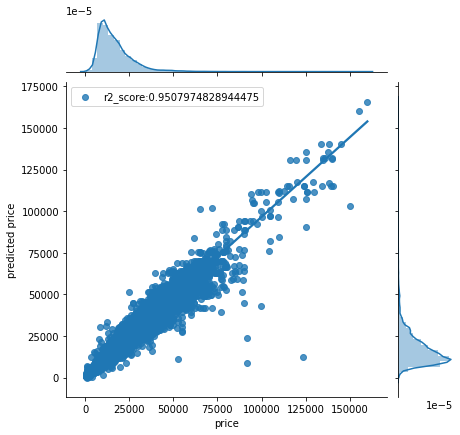

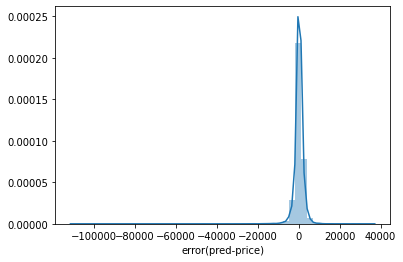

In [134]:
carPriceEmbed_c.plot_pred_price(features_list_c,y_c)

In [136]:
price_table = carPriceEmbed_c.price_diff(features_c,y_c,features_list_c)
price_table.head(20)

,model,transmission,fuelType,brand,mil_cat,binned_mpg,engine_binned,year,price_diff_pct,price_diff_abs
11984,Golf,Manual,Diesel,vw,0,3,0,2008,429.542594,429.542594
71819,Mondeo,Manual,Diesel,ford,0,2,0,2008,391.879383,391.879383
71617,Fiesta,Manual,Petrol,ford,4,2,0,2008,323.977775,323.977775
83274,Z4,Manual,Petrol,bmw,3,2,0,2014,303.705572,303.705572
77582,Santa Fe,Manual,Petrol,hyundi,4,1,1,2002,274.354329,274.354329
54464,Insignia,Manual,Petrol,vauxhall,4,1,1,2011,263.476516,263.476516
39978,A Class,Manual,Petrol,merc,5,1,0,2003,250.936073,250.936073
69135,Mondeo,Manual,Diesel,ford,4,2,0,2005,249.858507,249.858507
39540,M Class,Semi-Auto,Petrol,merc,5,1,1,2004,231.816455,231.816455
40170,A Class,Manual,Diesel,merc,5,3,0,2010,226.909650,226.909650


### The binned numeric value did better than original numerica data. 

--- 

### Let's focus on binned numeric value with original year embed model and adjust learning rate first 

2483/2483 [==============================] - 9s 4ms/step - loss: 380001760.0000 - MAPE: 100.0000 - MAE: 16813.8281 - val_loss: 386893376.0000 - val_MAPE: 99.9953 - val_MAE: 16875.1230


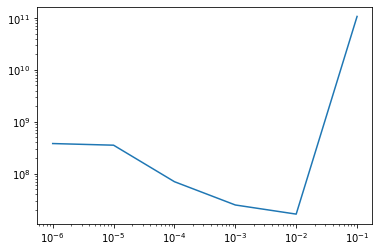

In [138]:
learning_rates = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
mdl_setup = partial(EmbedCarPrice.embed_model_setup, EMBED_COLS,NONEMBED_COLS,
                    X_train_c,numeric_size,model_size,DROPOUT,METRICS,embed_size_multiplier=2.0)
EmbedCarPrice.param_search(learning_rates,mdl_setup,X_train_dataset_c,X_dev_dataset_c,1)

### learning rate of 0.001 seems to work the best

### tune embed multiplier

In [142]:
mdl_partial = partial(EmbedCarPrice.embed_model_setup, EMBED_COLS,NONEMBED_COLS,
                    X_train_c,numeric_size,model_size,DROPOUT,METRICS,0.001)

2483/2483 [==============================] - 9s 4ms/step - loss: 23690432.0000 - MAPE: 19.0371 - MAE: 2787.0066 - val_loss: 15810845.0000 - val_MAPE: 13.8632 - val_MAE: 2141.5542


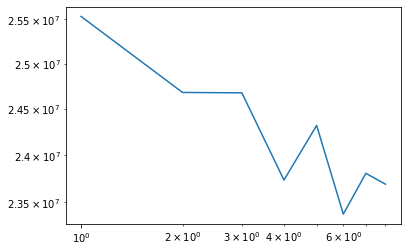

In [145]:
multiplier = [1,2,3,4,5,6,7,8]
EmbedCarPrice.param_search(multiplier,mdl_partial,X_train_dataset_c,X_dev_dataset_c,1)

### multipler of 3 seems to work the best

In [146]:
final_mdl = mdl_partial(3)

In [147]:
final_mdl.summary()

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_257 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_258 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_259 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_260 (InputLayer)          [(None, 1)]          0                                            
___________________________________________________________________________________________

In [152]:
carPriceEmbed_c_final = EmbedCarPrice(final_mdl,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [153]:
carPriceEmbed_c_final.regression_metrics(X_train_list_c,y_train_c,"train",True,X_train_dataset_c,X_dev_dataset_c,0)

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping


,r2_score,rmse,price_diff_abs_max
train,0.955226,2087.190411,313.252613


In [154]:
carPriceEmbed_c_final.regression_metrics(X_test_list_c,y_test_c,"test",False)

,r2_score,rmse,price_diff_abs_max
test,0.947125,2218.078166,139.182705


In [155]:
carPriceEmbed_c_final.save_model("final_embed_mdl.h5")

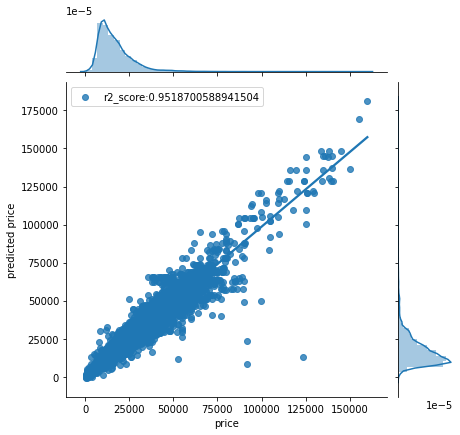

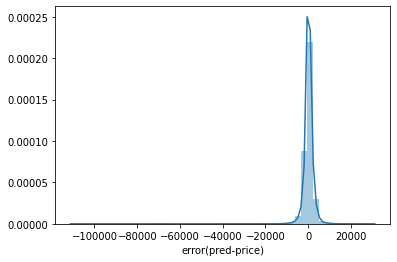

In [157]:
carPriceEmbed_c_final.plot_pred_price(features_list_c,y_c)

In [179]:
price_table = carPriceEmbed_c_final.price_diff(features_c,y_c,features_list_c)
price_table.head(20)

,model,transmission,fuelType,brand,mil_cat,binned_mpg,engine_binned,year,price_diff_pct,price_diff_abs
72161,KA,Manual,Petrol,ford,4,2,0,2008,1965.715654,1965.715654
54900,Agila,Manual,Petrol,vauxhall,4,2,0,2003,1924.808377,1924.808377
72284,KA,Manual,Petrol,ford,4,2,0,2008,1832.051700,1832.051700
71100,KA,Manual,Petrol,ford,4,2,0,2006,1714.666453,1714.666453
71820,Fiesta,Manual,Petrol,ford,4,2,0,2004,1627.044819,1627.044819
71617,Fiesta,Manual,Petrol,ford,4,2,0,2008,1608.916972,1608.916972
71564,KA,Manual,Petrol,ford,4,2,0,2007,1601.313495,1601.313495
69135,Mondeo,Manual,Diesel,ford,4,2,0,2005,1594.210069,1594.210069
72349,Focus,Manual,Petrol,ford,4,2,0,2005,1480.555351,1480.555351
83274,Z4,Manual,Petrol,bmw,3,2,0,2014,1370.400378,1370.400378


### Conclusions

### More tuning on dropout and other params can enhance the models but embed gives the best results